In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import json
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from einops import repeat
from models.cvae import CVAEv1, CVAEv2

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v10'
split = 'system'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_499491/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


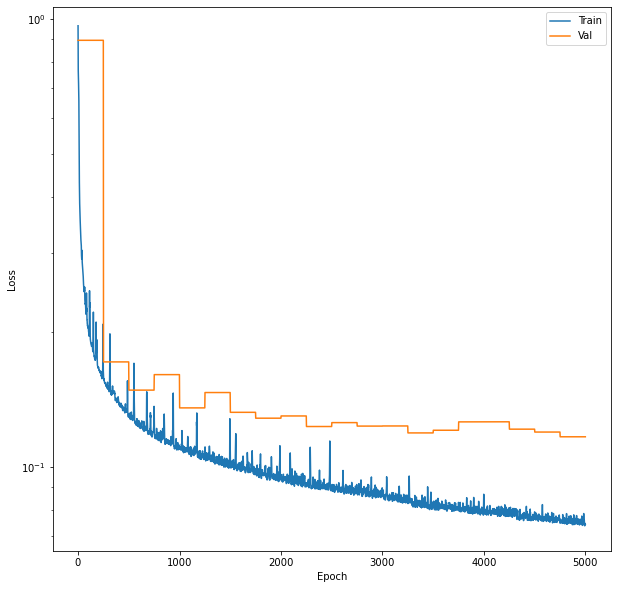

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Load model
# model = CVAEv1(**configs['model_params'])
model = CVAEv2(**configs['model_params'])

model.load_state_dict(torch.load(f'runs/{model_type}/{split}/{fname}/best_model.pt', map_location=configs['device']))
model = model.to(configs['device'])
model.eval()

# Load test set
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, test_dataset = dataset.train_val_test_split(mode=split, both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

# Get test zeolites and OSDAs
zeo_code, zeo, osda_smiles, osda, = test_dataset[3], test_dataset[5], test_dataset[13], test_dataset[15], 

if not os.path.isfile(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv'): # If synthetic predictions not already saved
    print('Systems not predicted yet, predicting and saving...')
    # Predict synthesis conditions
    zeo_code = repeat(np.array(zeo_code), 'n -> (repeat n)', repeat = 50)
    zeo = repeat(zeo, 'n d -> (repeat n) d', repeat = 50)
    osda_smiles = repeat(np.array(osda_smiles), 'n -> (repeat n)', repeat = 50)
    osda = repeat(osda, 'n d -> (repeat n) d', repeat = 50)
    zeo, osda = zeo.to(configs['device']), osda.to(configs['device'])
    syn_pred = torch.tensor(model.predict(zeo, osda).cpu().detach().numpy())

    # Scale synthesis conditions back
    for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
        qt = dataset.qts[ratio] # load quantile transformer
        syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
    syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
    syn_pred['zeo'], syn_pred['osda'] = zeo_code, osda_smiles
    syn_pred.to_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv', index=False) # Save synthetic predictions
else:
    print('Loading synthetic predictions from saved predictions...')
    syn_pred = pd.read_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv')

syn_pred.shape

SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


(258400, 14)

In [6]:
# Get ground truth
syn_true, zeo_code, osda_smiles = test_dataset[1], test_dataset[3], test_dataset[13]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true['zeo'], syn_true['osda'] = zeo_code, osda_smiles
syn_true.shape

(5168, 14)

# Aggregated

In [7]:
# # to be transfers to similarity.py
# def maximum_mean_discrepancy(X, Y, kernel_type='gaussian', sigmas=None):
#     """
#     Calculate the Maximum Mean Discrepancy (MMD) between two distributions.

#     Parameters:
#     - X: Samples from the first distribution (numpy array or PyTorch tensor).
#     - Y: Samples from the second distribution (numpy array or PyTorch tensor).
#     - kernel_type: Type of kernel function ('linear', 'gaussian', etc.).
#     # - gamma: Parameter for the Gaussian kernel (if kernel_type is 'gaussian').
#     - sigmas: List of floats. Standard deviation(s) of the Gaussian kernel (if kernel_type is 'gaussian').

#     Returns:
#     - mmd: Maximum Mean Discrepancy between X and Y.
#     """
#     X, Y = np.asarray(X), np.asarray(Y)

#     if isinstance(X, np.ndarray) and isinstance(Y, np.ndarray):
#         X, Y = torch.from_numpy(X), torch.from_numpy(Y)

#     if not torch.is_tensor(X):
    #     raise ValueError("Input X should be a numpy array or a PyTorch tensor.")

    # if not torch.is_tensor(Y):
    #     raise ValueError("Input Y should be a numpy array or a PyTorch tensor.")

    # if X.dim() != 2 or Y.dim() != 2:
    #     raise ValueError("Input tensors should be 2-dimensional.")

    # if X.size(1) != Y.size(1):
    #     raise ValueError("Input tensors should have the same number of features.")

    # if kernel_type == 'linear':
    #     K_XX = torch.mm(X, X.t())
    #     K_YY = torch.mm(Y, Y.t())
    #     K_XY = torch.mm(X, Y.t())

    # elif kernel_type == 'gaussian':
    #     if sigmas is None:
    #         sigmas = [3., 4., 5., 7.]

    #     X_norm = torch.sum(X * X, dim=1).unsqueeze(1)
    #     Y_norm = torch.sum(Y * Y, dim=1).unsqueeze(1)

    #     d_XX = X_norm - 2 * torch.mm(X, X.t()) + X_norm.t()
    #     d_YY = Y_norm - 2 * torch.mm(Y, Y.t()) + Y_norm.t()
    #     # print(X_norm.shape, Y_norm.t().shape, torch.mm(X, Y.t()).shape)
    #     d_XY = X_norm - 2 * torch.mm(X, Y.t()) + Y_norm.t()

    #     # K_XX = torch.exp(-0.5*d_XX/(sigma**2)) # next step: remove diagonal, diagonal should be np.ones
    #     # K_YY = torch.exp(-0.5*d_YY/(sigma**2)) # same as above
    #     # K_XY = torch.exp(-0.5*d_XY/(sigma**2)) # no need to remove diagonal because no self-distance
        
    #     K_XX, K_YY, K_XY = torch.zeros(d_XX.shape), torch.zeros(d_YY.shape), torch.zeros(d_XY.shape)
    #     for sigma in sigmas: # different bandwidths as implemented in https://arxiv.org/pdf/2402.03008.pdf
    #         K_XX += torch.exp(-0.5*d_XX/(sigma**2)) # next step: remove diagonal, diagonal should be np.ones
    #         K_YY += torch.exp(-0.5*d_YY/(sigma**2)) # same as above
    #         K_XY += torch.exp(-0.5*d_XY/(sigma**2)) # no need to remove diagonal because no self-distance
    #     K_XX.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    #     K_YY.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    #     # print(K_XX.shape), print(K_YY.shape), print(K_XY.shape)
    #     print(K_XX), print(K_YY), print(K_XY)

    # else:
    #     raise ValueError("Unsupported kernel type. Supported types are 'linear' and 'gaussian'.")

    # # mmd = torch.mean(K_XX) - 2 * torch.mean(K_XY) + torch.mean(K_YY) # square root this MMD^2

    # mmd = K_XX.sum()/(K_XX.size(0)**2 - len(K_XX.diagonal())) - 2*torch.mean(K_XY) + K_YY.sum()/(K_YY.size(0)**2 - len(K_YY.diagonal())) # square root this MMD^2
    
    # # K_XY.fill_diagonal_(0.)
    # # mmd = K_XX.sum()/(K_XX.size(0)**2 - len(K_XX.diagonal())) - 2 * K_XY.sum()/(K_XY.shape[0]*K_YY.shape[1] - len(K_XY.diagonal())) + K_YY.sum()/(K_YY.size(0)**2 - len(K_YY.diagonal())) # square root this MMD^2

    # return mmd.item()

def maximum_mean_discrepancy(x, y, kernel='rbf'):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    x, y = np.asarray(x), np.asarray(y)

    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x, y = torch.from_numpy(x), torch.from_numpy(y)

    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    rx_ = (xx.diag().unsqueeze(1).expand_as(xy)) # rx in shape of xy
    ry_ = (yy.diag().unsqueeze(0).expand_as(xy)) # ry in shape of xy
    # rx = torch.sum(xx, dim=1).unsqueeze(1)
    # ry = torch.sum(yy, dim=1).unsqueeze(1)
    # rx = torch.norm(xx)
    # ry = torch.norm(yy)
    # print(rx.shape, ry.shape)

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    # print(rx.t().shape, ry.shape, xy.shape)
    # dxy = rx.t() + ry - 2. * xy # Used for C in (1)
    # print(rx_.shape, ry_.shape, xy.shape)
    dxy = rx_ + ry_ - 2. * xy # Used for C in (1)

    # dxx = rx + rx.t() - 2. * xx # Used for A in (1)
    # dyy = ry + ry.t() - 2. * yy # Used for B in (1)
    # print(rx.shape, ry.t().shape, xy.shape)
    # dxy = rx + ry.t() - 2. * xy # Used for C in (1)


    XX, YY, XY = (torch.zeros(xx.shape),
                  torch.zeros(yy.shape),
                  torch.zeros(xy.shape))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        # bandwidth_range = [10, 15, 20, 50]
        bandwidth_range = [2e-3, 2e-2, 2e-1, 2e0, 2e1, 2e2, 2e3]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    # return torch.mean(XX + YY - 2. * XY)
    # print(torch.mean(XX), torch.mean(YY), 2. * torch.mean(XY))
        
    # return (torch.mean(XX) + torch.mean(YY) - 2. * torch.mean(XY)).item()

    # exclude diagonals of XX and YY
    XX.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    YY.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    return torch.sum(XX)/(XX.shape[0]**2 - len(XX.diagonal())) + torch.sum(YY)/(YY.shape[0]**2 - len(YY.diagonal())) - 2. * torch.mean(XY)
    
    # XX.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    # YY.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    # XY.fill_diagonal_(0.) # remove 1.0s from diagonals (no self-distance)
    # # print(XX), print(YY), print(XY)
    # return torch.sum(XX)/(XX.size(0)**2 - len(XX.diagonal())) + torch.sum(YY)/(YY.size(0)**2 - len(YY.diagonal())) - 2. * (torch.sum(XY)/(XY.shape[0]*XY.shape[1] - len(XY.diagonal())))

In [8]:
a = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], 
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              ])
maximum_mean_discrepancy(a, a[1:,:])

tensor(-0.4594)

In [9]:
a, b = np.random.randn(100*50 , 2), np.random.randn(2, 2)
maximum_mean_discrepancy(a, b)

tensor(0.8079)

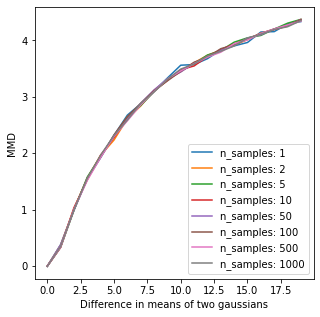

In [ ]:
# plt.figure(figsize=(5,5))
# mmds_vs_n_samples = {}
# for n_samples in [1, 2, 5, 10, 50, 100, 500, 1000]:
#     mmds = []
#     diffs = np.arange(0,20)
#     for diff in diffs:
#         a, b = np.random.randn(50*n_samples, 12)+1, np.random.randn(100, 12)+1+diff
#         # mmds.append(maximum_mean_discrepancy(a, b, 'gaussian', sigmas = None))
#         mmds.append(maximum_mean_discrepancy(a, b))
#     # print('mmds:', mmds)
#     mmds_vs_n_samples[n_samples] = mmds
#     plt.plot(diffs, mmds, label=f'n_samples: {n_samples}')

# plt.legend()
# plt.xlabel('Difference in means of two gaussians')
# plt.ylabel('MMD')
# plt.show()

In [10]:
# compare predictions and true
idxs = np.random.choice(syn_pred.index, size=30000) # sample points from predictions
maximum_mean_discrepancy(np.array(syn_pred[dataset.ratio_names+dataset.cond_names].iloc[idxs], dtype=np.double), np.array(syn_true[dataset.ratio_names+dataset.cond_names], dtype=np.double))

tensor(0.0243)

In [246]:
# compare predictions with itself - should be 0.
p = np.array(syn_true[dataset.ratio_names+dataset.cond_names], dtype=np.double)
maximum_mean_discrepancy(p, p)

tensor(-0.0027)

# Overall aggregated

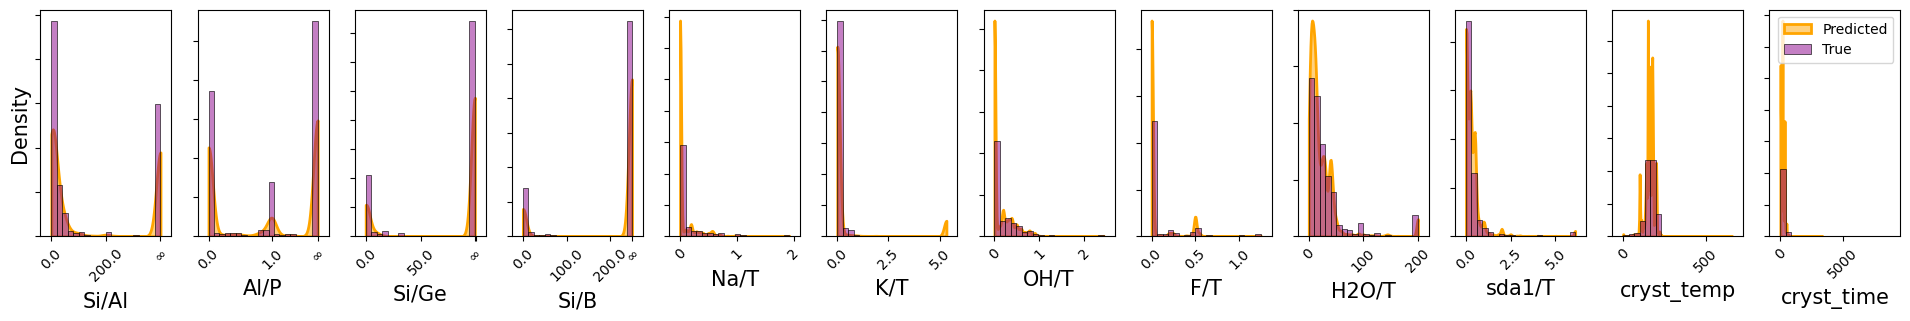

In [7]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], [True, False], [False, True], ['orange', 'darkmagenta'], common_norm=True, alpha=0.5)

# System

### Zeolite-aggregated systems

CHA


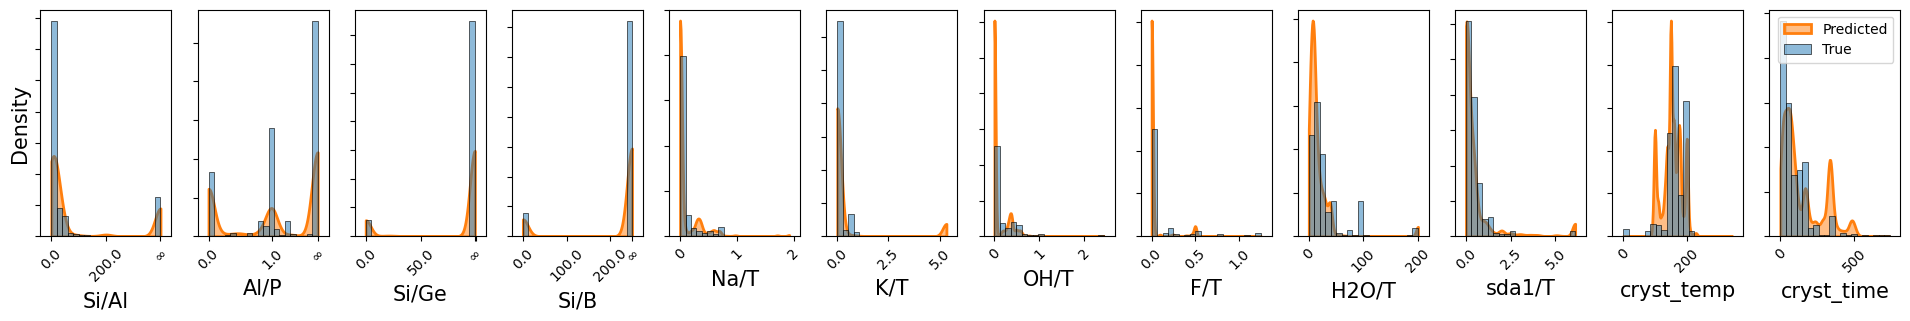

MFI


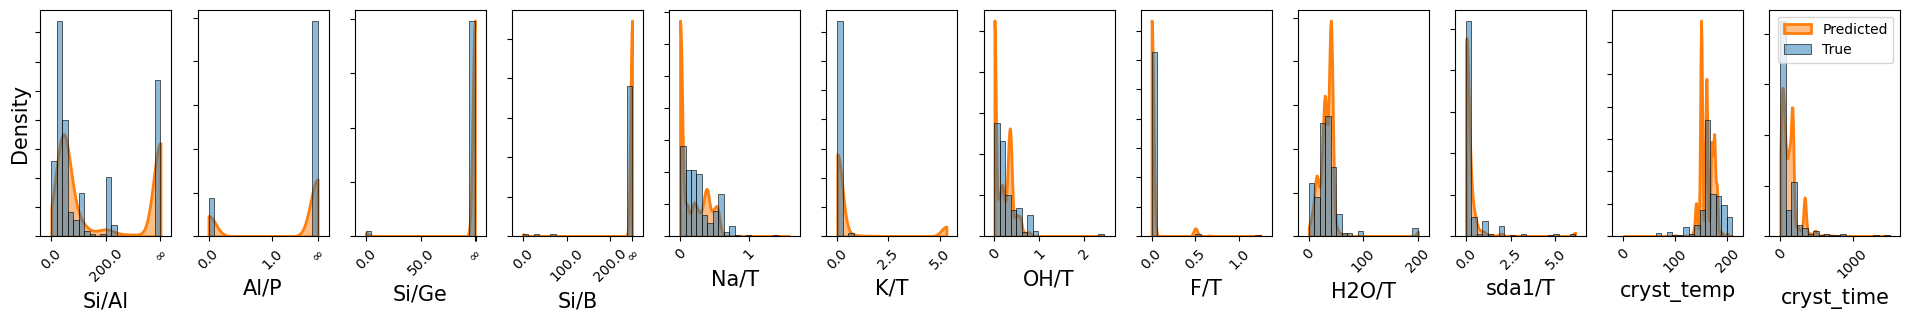

AEL


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


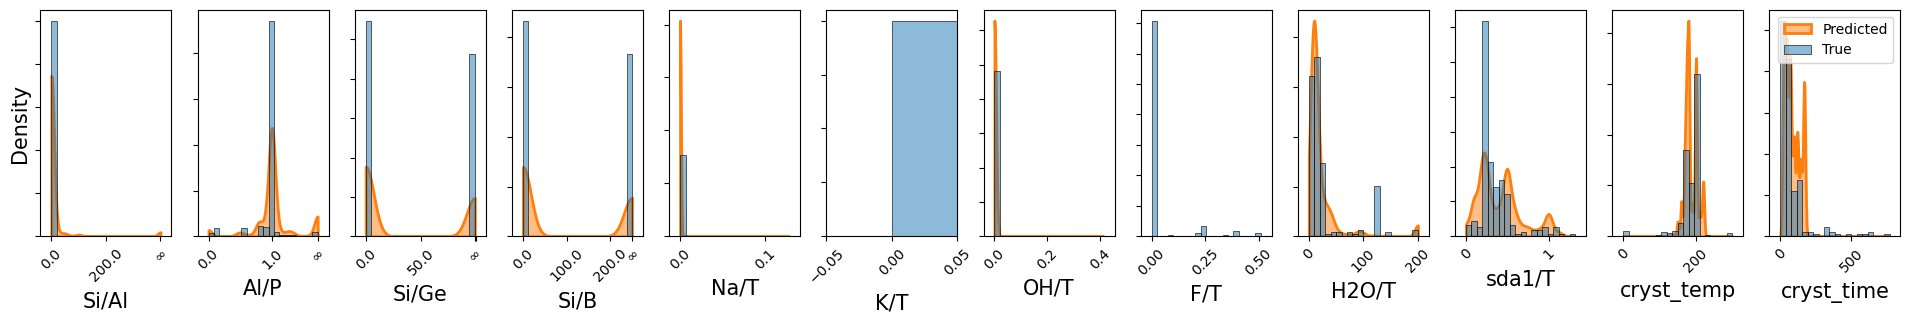

MEL


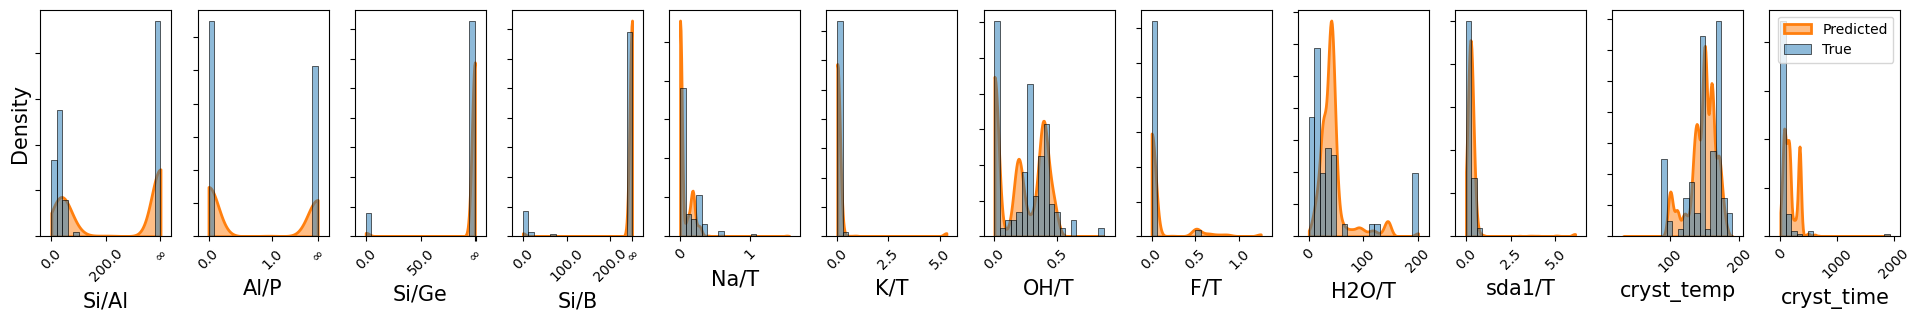

AFI


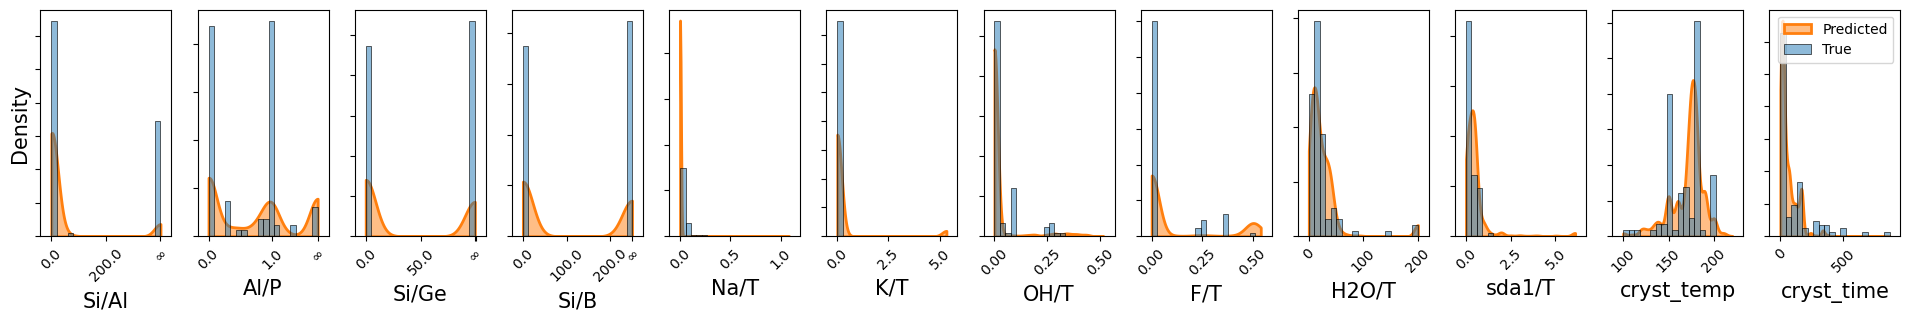

AEI


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


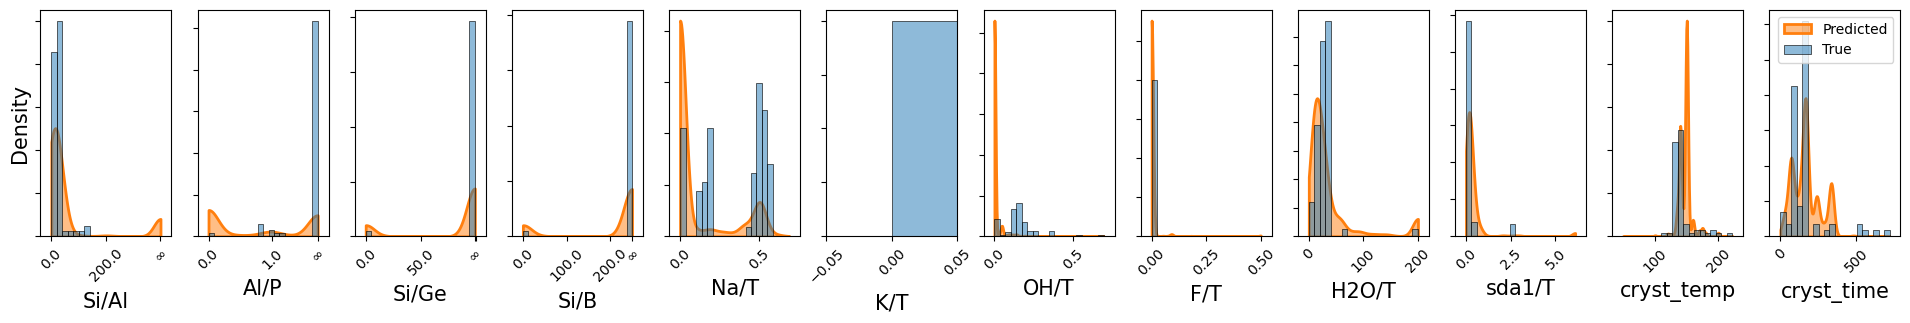

BEA


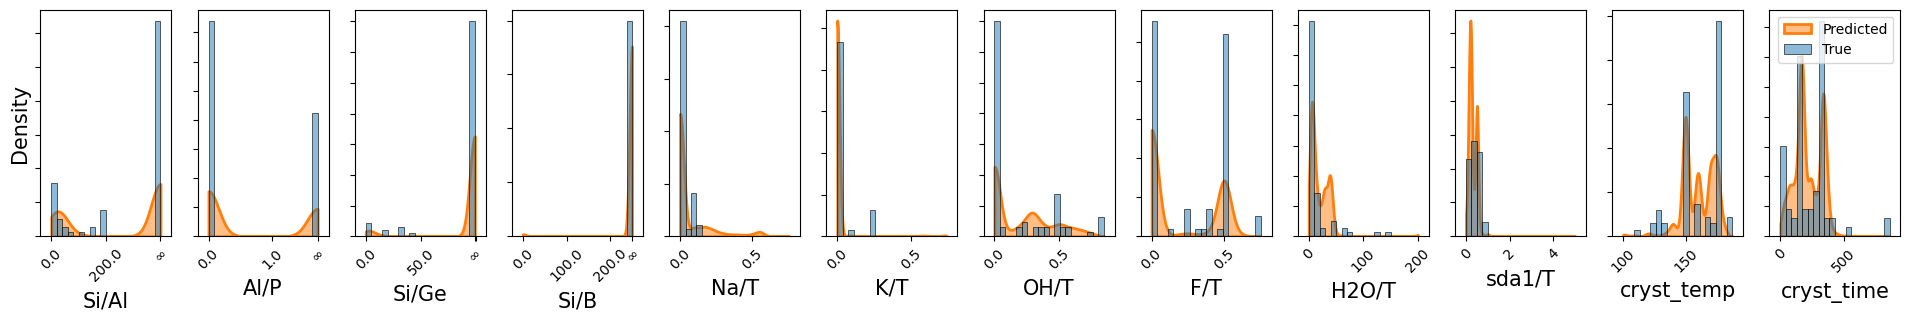

MTW


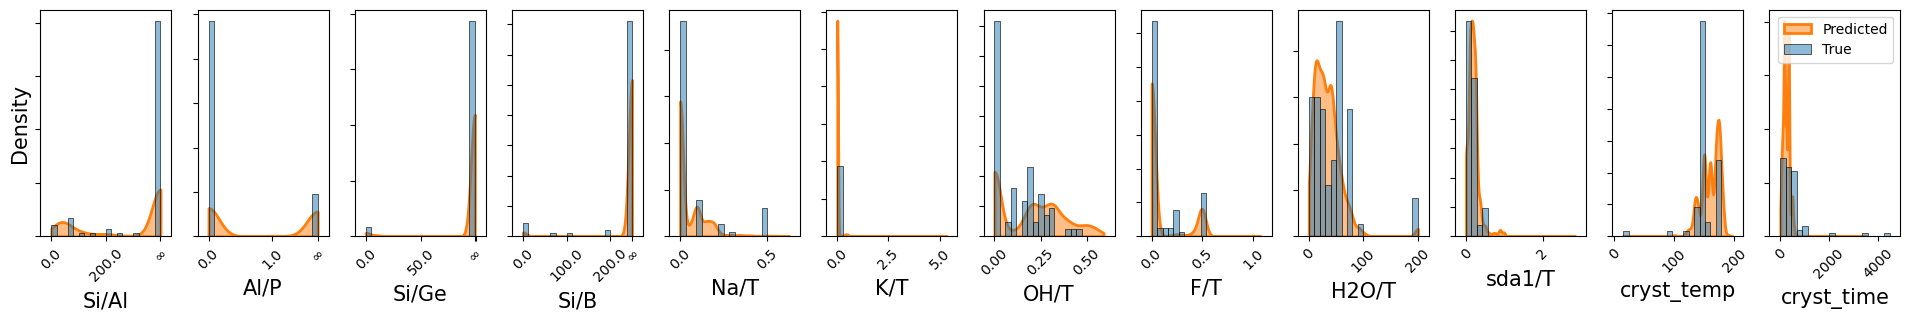

EMT


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


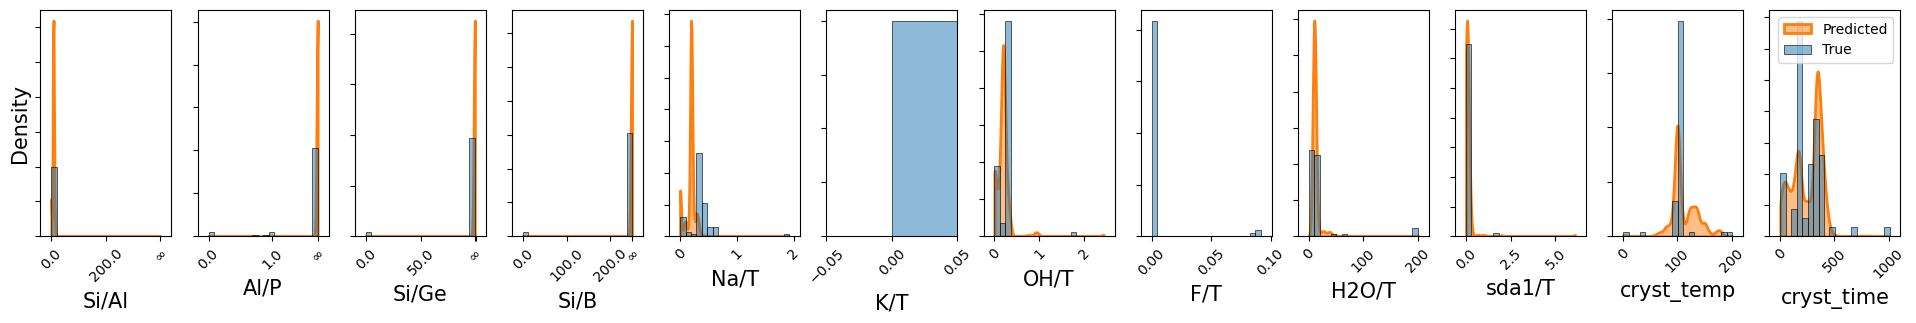

ATO


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

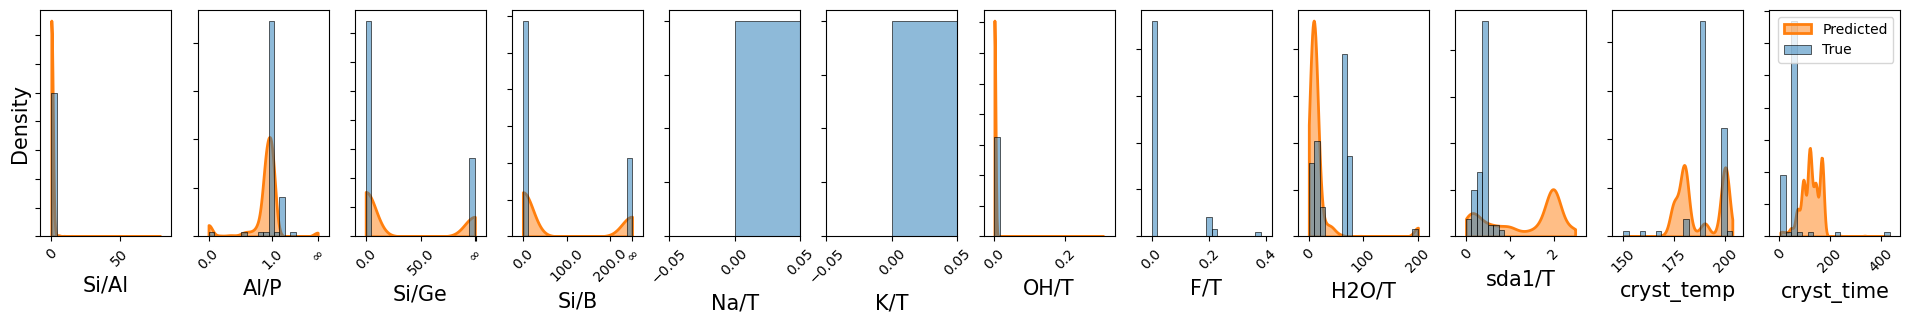

In [8]:
# Top 10 most/least common zeolites in test set
zeo_systems = list(syn_true['zeo'].value_counts().index)
count = 0
for zeo in zeo_systems:
# for zeo in reversed(zeo_systems):
    if zeo != 'Dense/Amorphous':
        print(zeo)
        sys_syn_pred = syn_pred[syn_pred['zeo'] == zeo]
        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        
        count += 1
    if count == 10:
        break

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


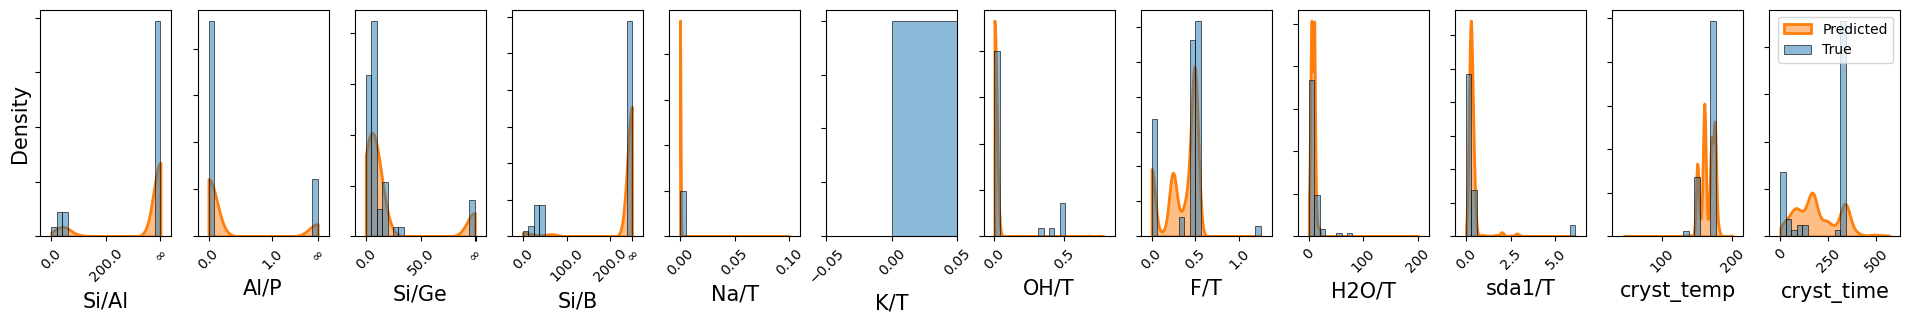

In [9]:
# BEC - observe Si/Ge and F/T
zeo = 'BEC'
sys_syn_pred = syn_pred[syn_pred['zeo'] == zeo]
sys_syn_true = syn_true[syn_true['zeo'] == zeo]
utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)

### Zeolite-OSDA system

CHA C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


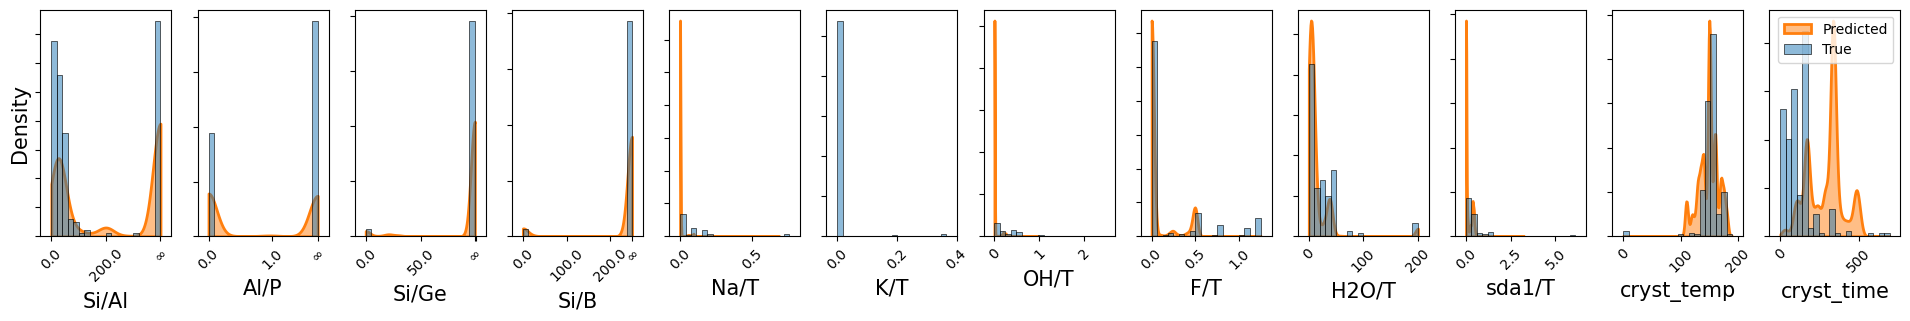

AEL CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


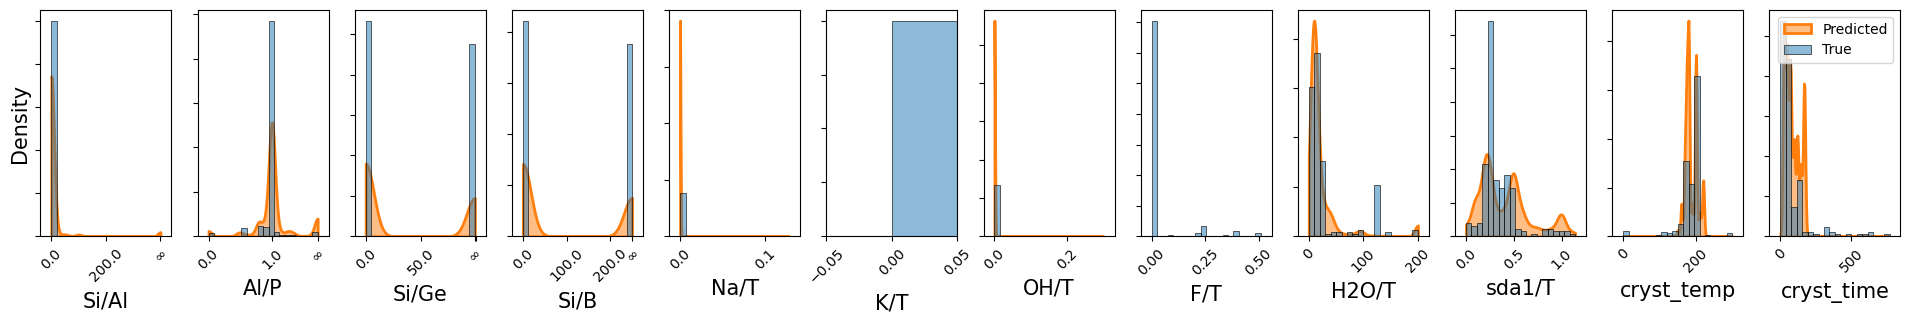

CHA OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


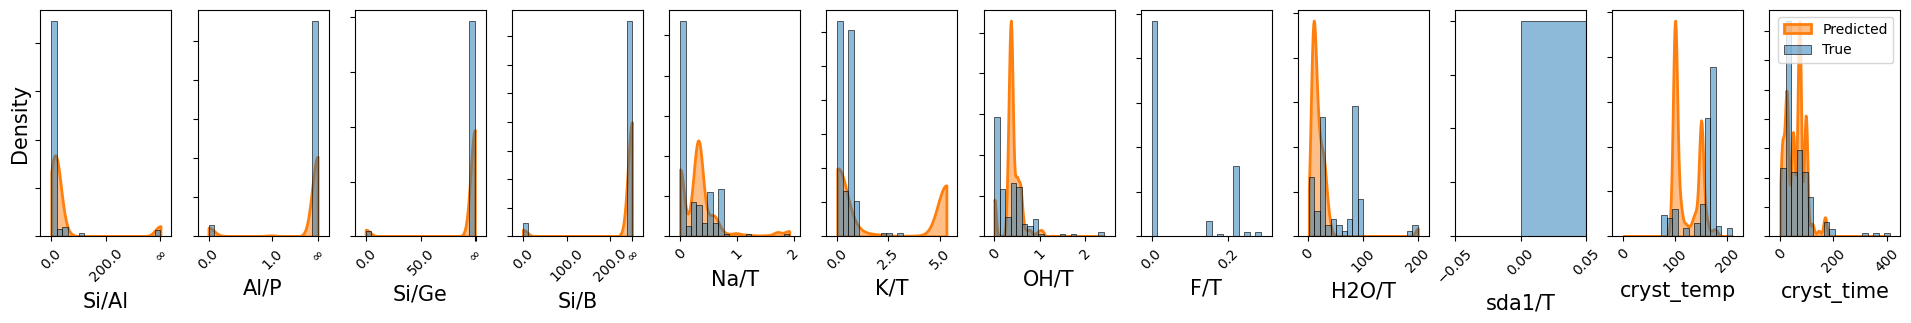

MFI OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


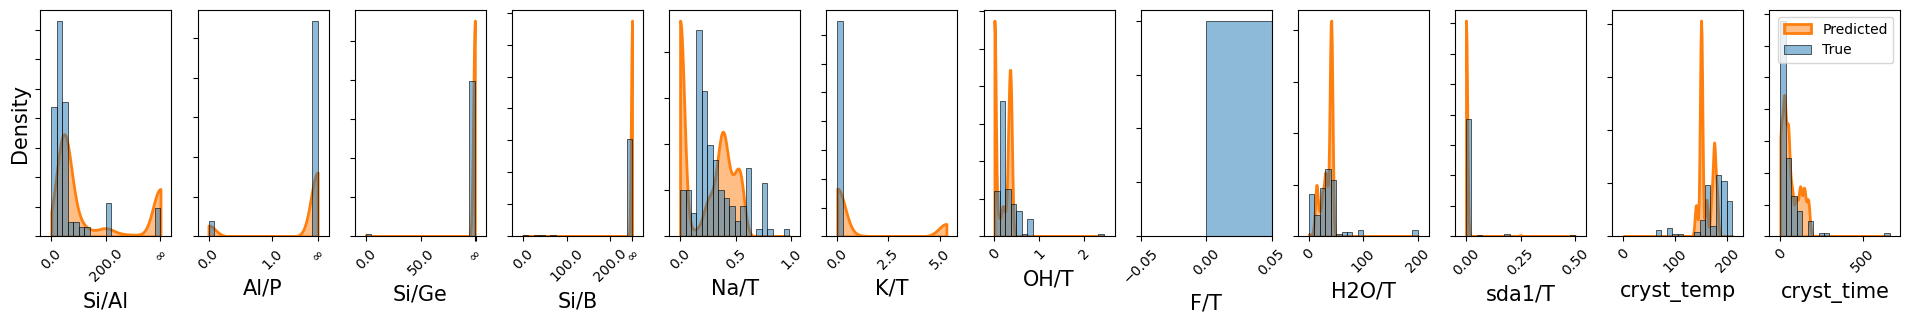

CHA CCN(CC)CC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


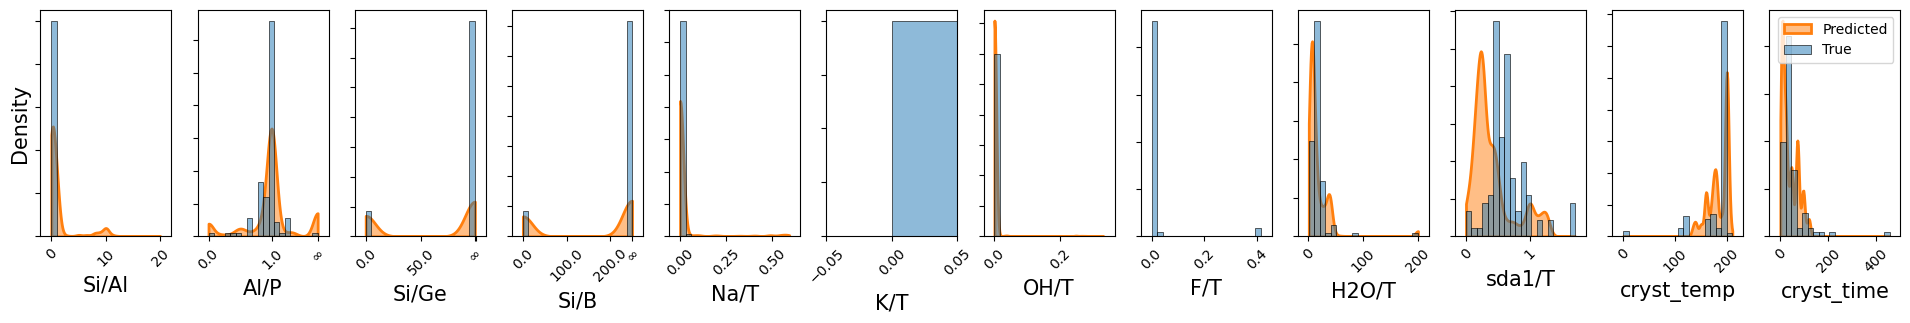

MEL CCCC[N+](CCCC)(CCCC)CCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


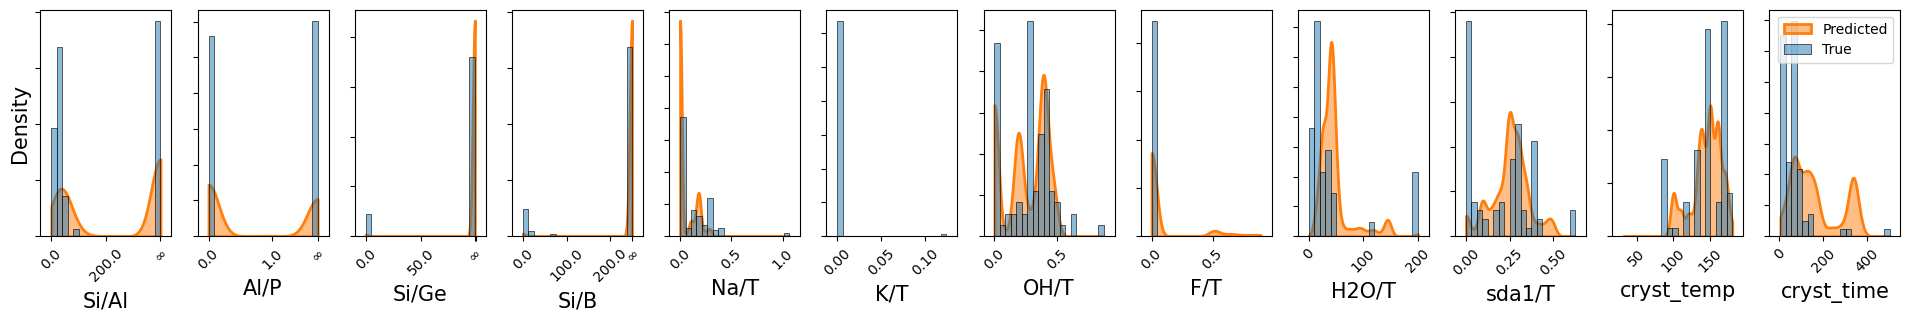

CHA C1COCCN1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


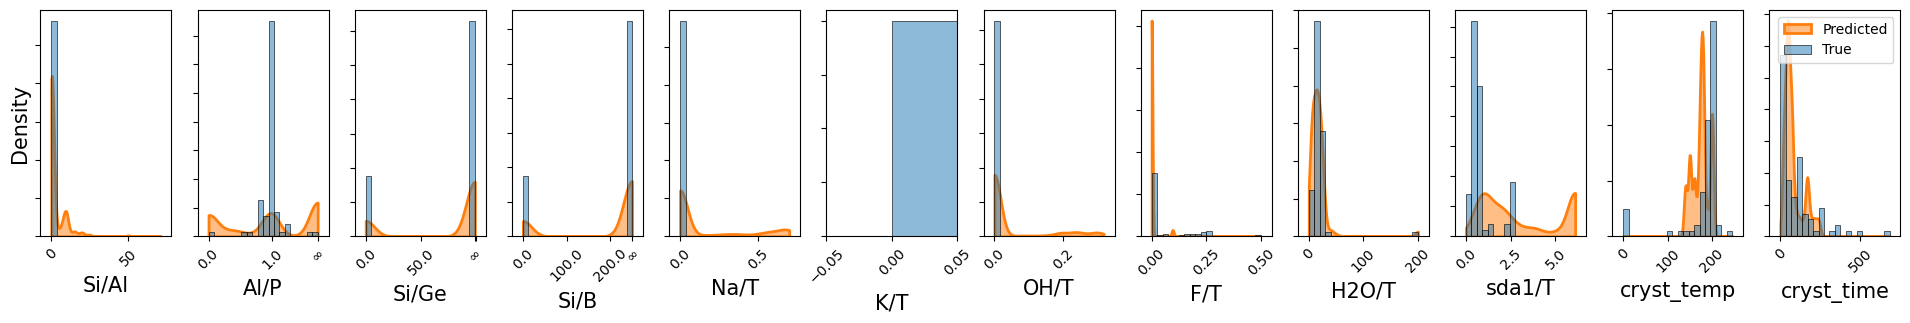

ATO CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

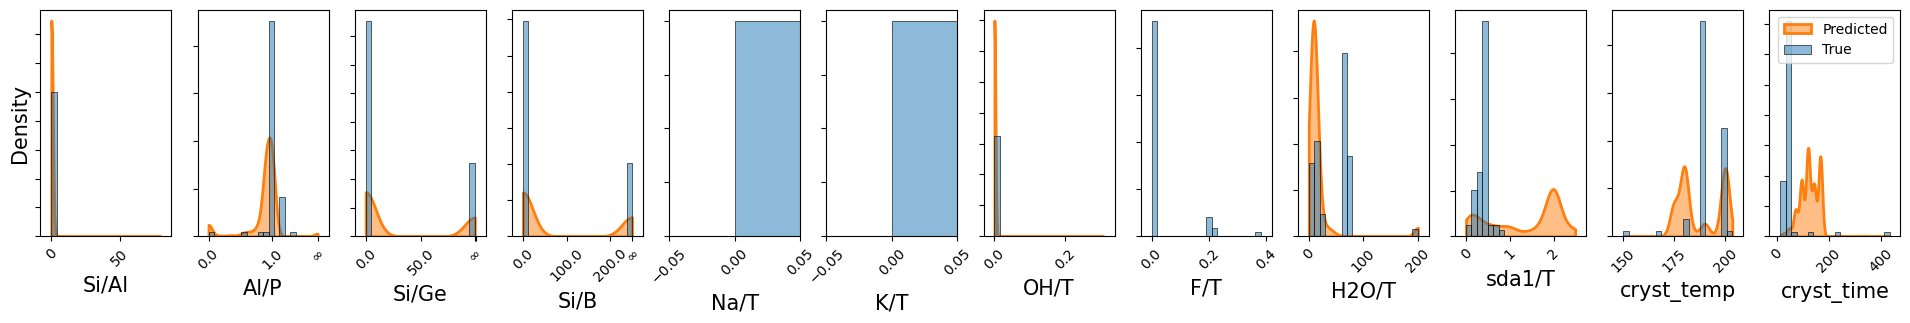

AEI CC1CC(C)C[N+](C)(C)C1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


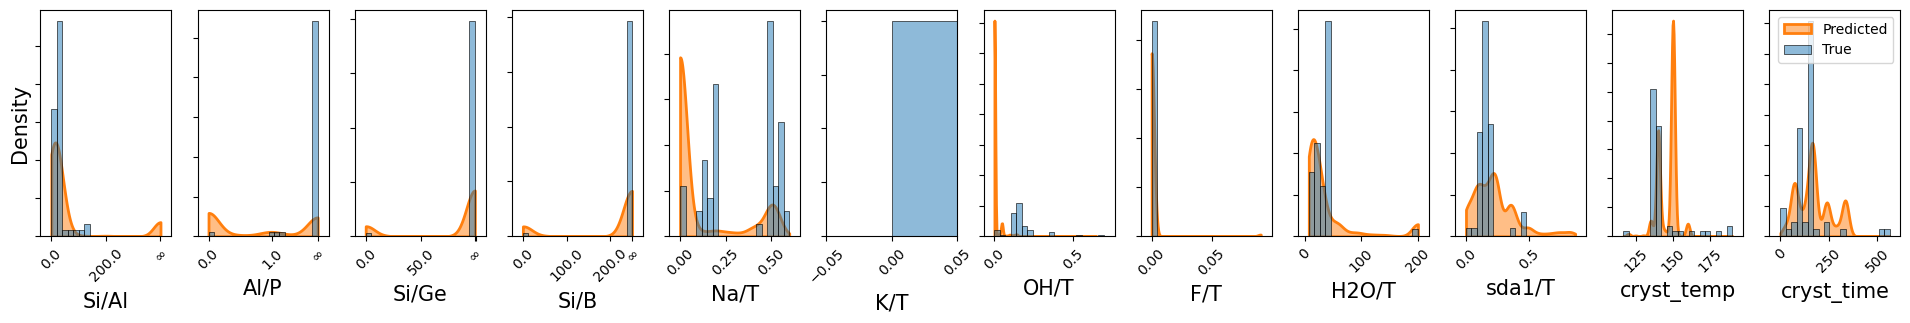

IMF C[N+]1(CCCCC[N+]2(C)CCCC2)CCCC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


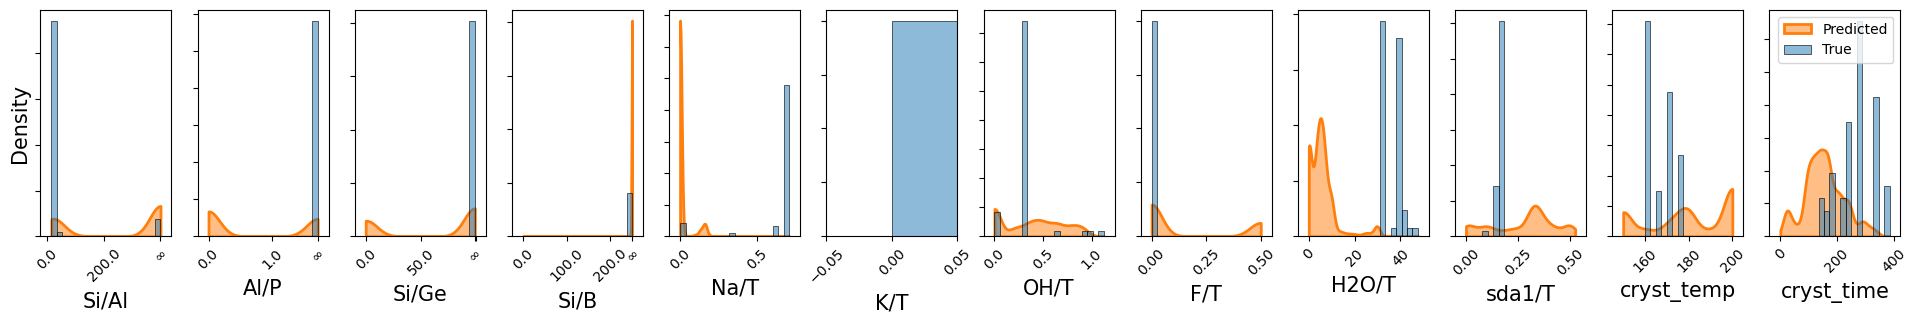

IWR CC[N+]1(CC)CC2C3C(C)=CC(C)(C2C1)C1C[N+](CC)(CC)CC31


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


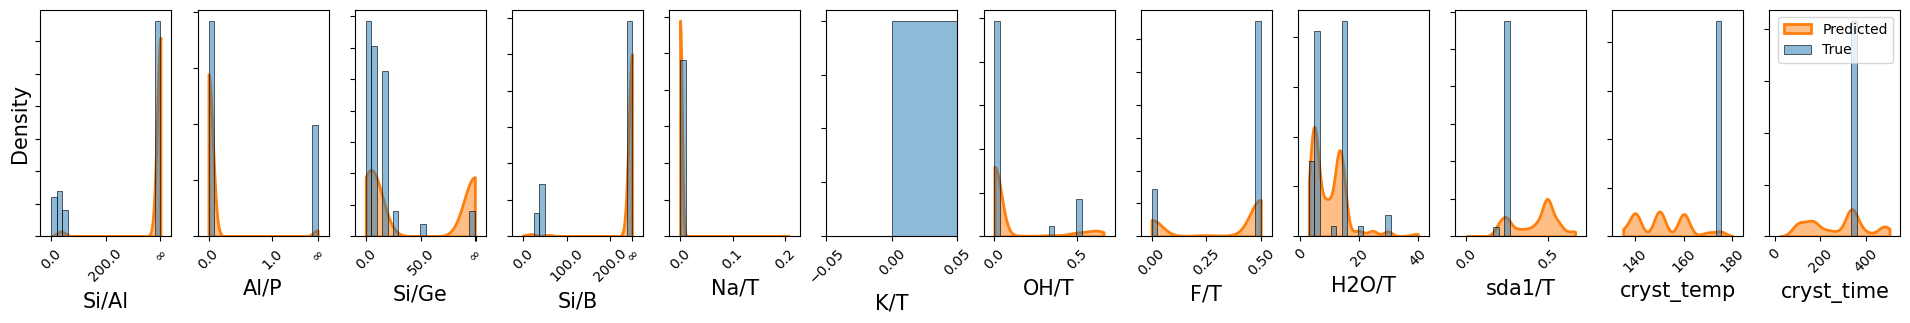

EMT C1COCCOCCOCCOCCOCCO1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


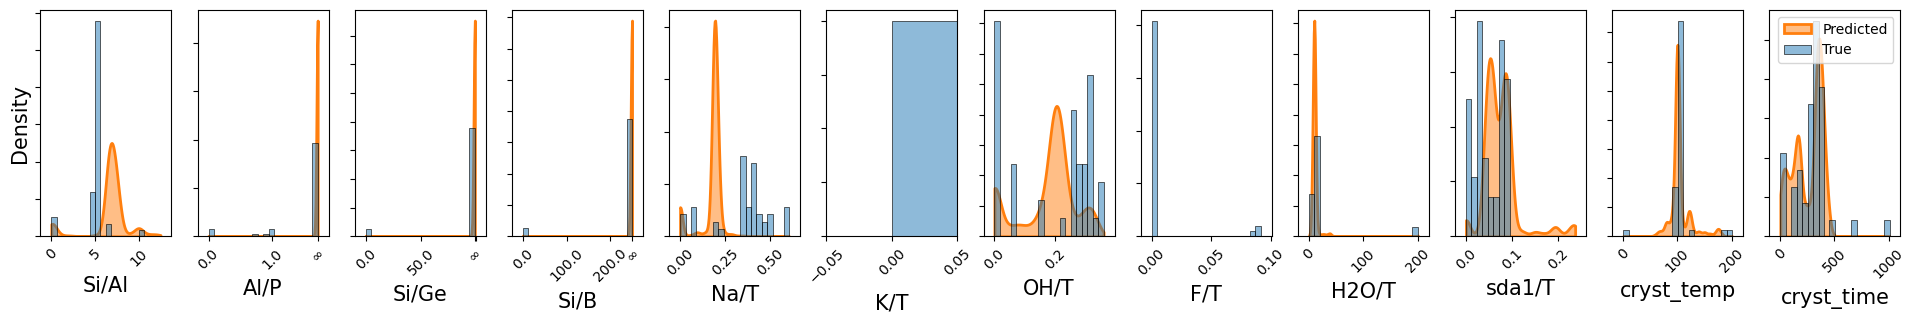

CHA CCNCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


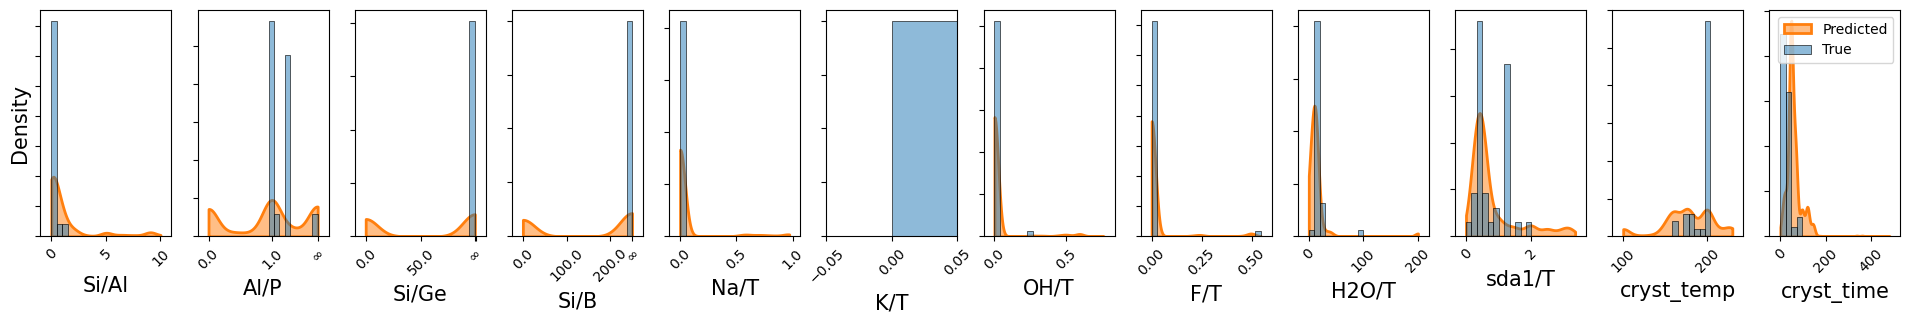

SFO CN(C)c1ccncc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

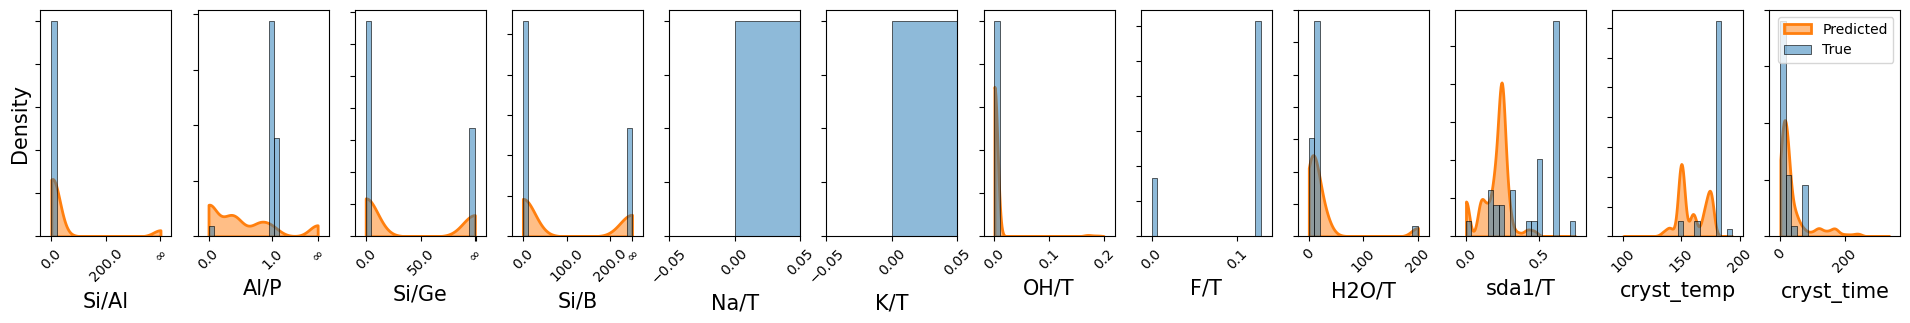

AFI C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


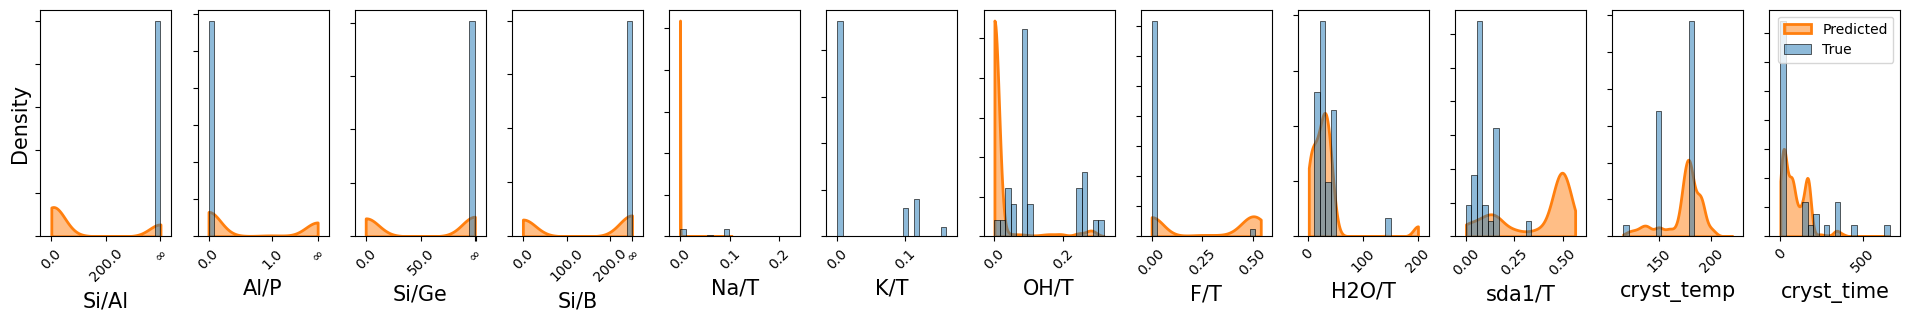

UTL C[C@H]1CCC[C@@H](C)[N+]12CCCC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

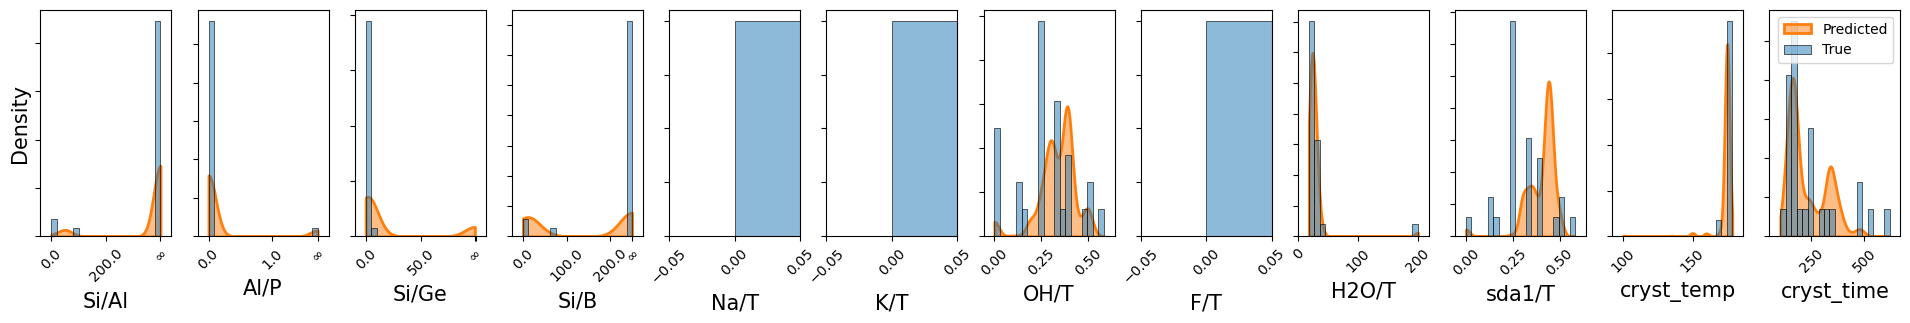

In [10]:
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in zeo_osda_systems:
# for zeo, osda in reversed(zeo_osda_systems):
    if zeo != 'Dense/Amorphous':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        
        count += 1
    if count > 15:
        break

### BEC systems

BEC c1ccc(C[N+]23CCC(CC2)CC3)cc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

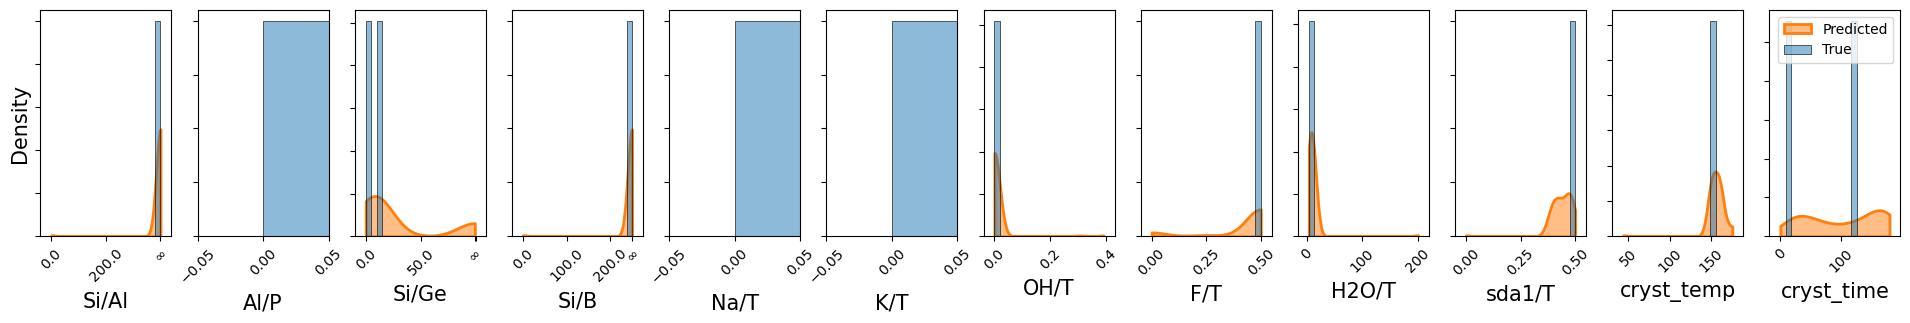

BEC c1cc(C[N+]23CCC(CC2)CC3)ccc1C[N+]12CCC(CC1)CC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 250.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_ran

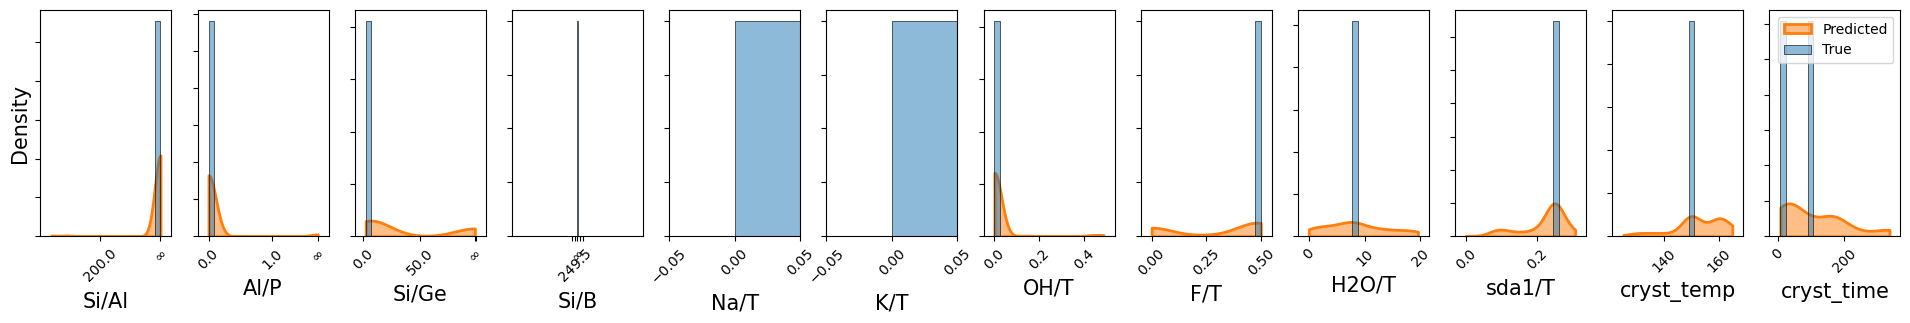

BEC C(CC[N+]12CCN(CC1)CC2)C[N+]12CCN(CC1)CC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


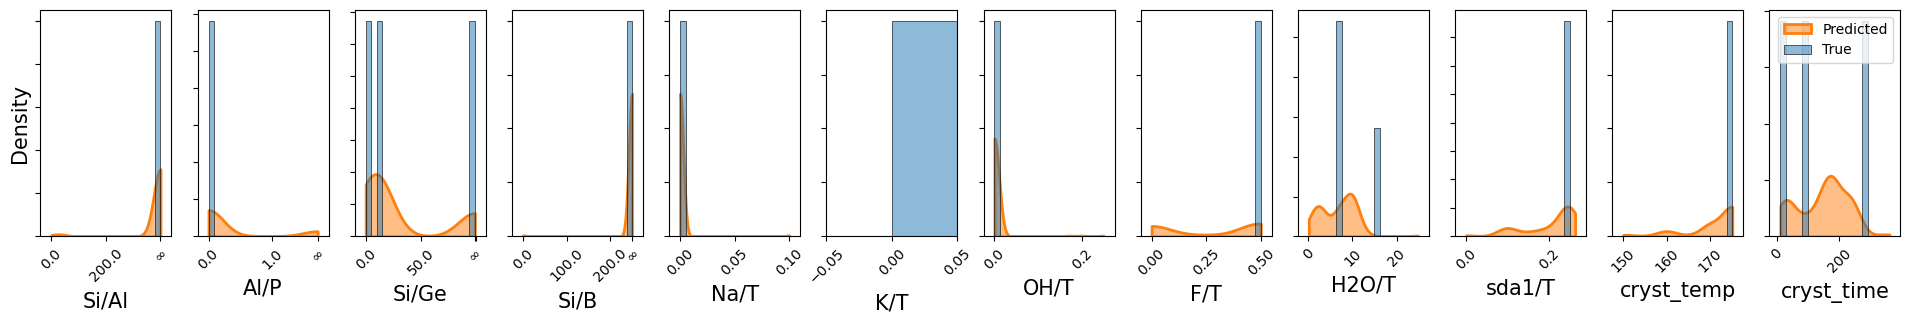

BEC CN(C)CCN(C)C


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

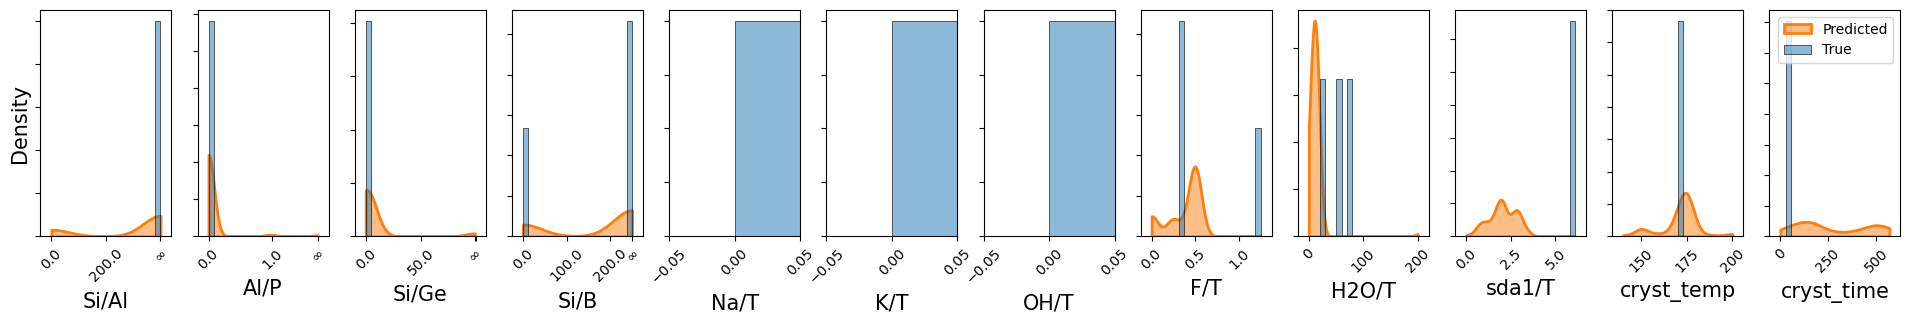

BEC CCC[N+]1(CCC)CCC([N+]2(CCC)CCCC2)CC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


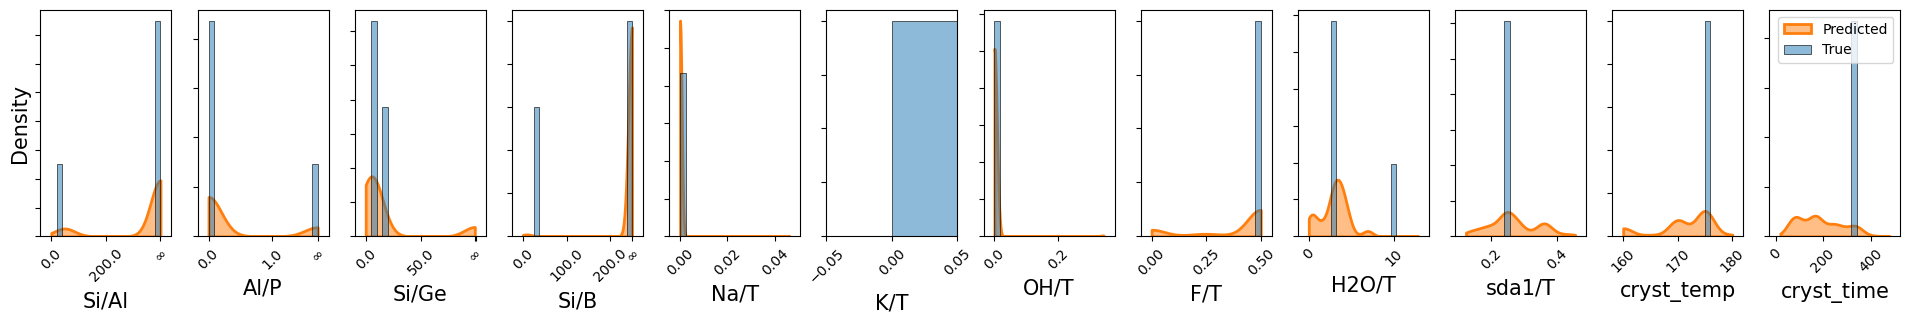

BEC c1ccc(C[N+]23CCN(CC2)CC3)cc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

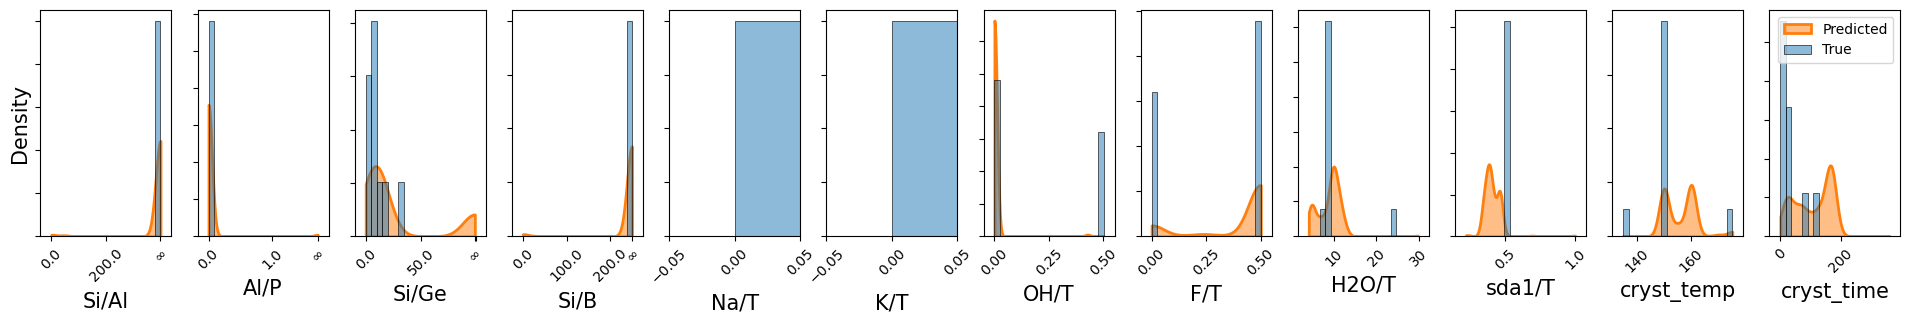

BEC C[N+]1(C)CCC([N+]2(C)CCCC2)CC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

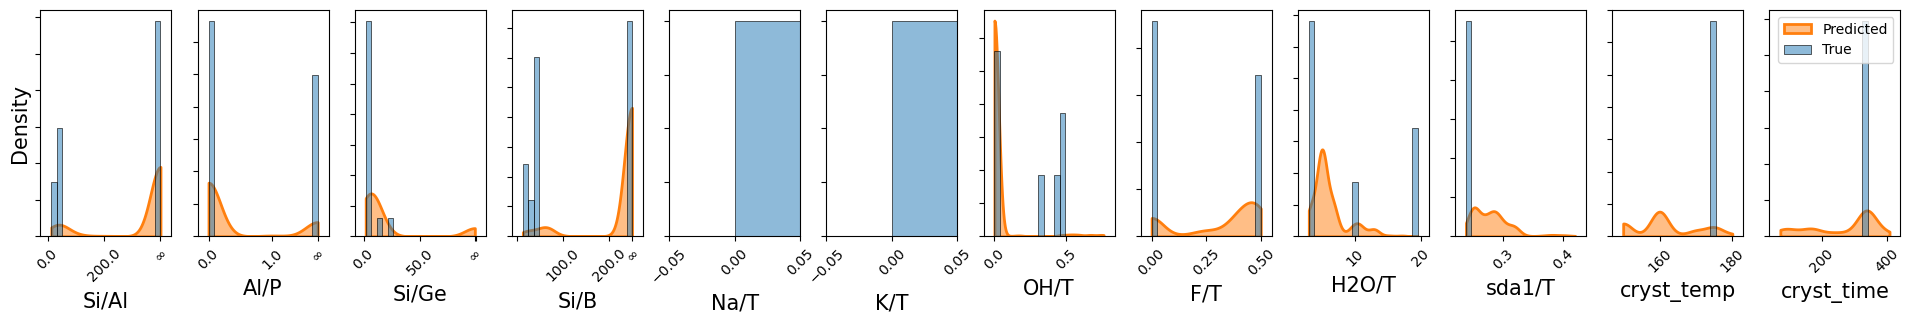

BEC C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

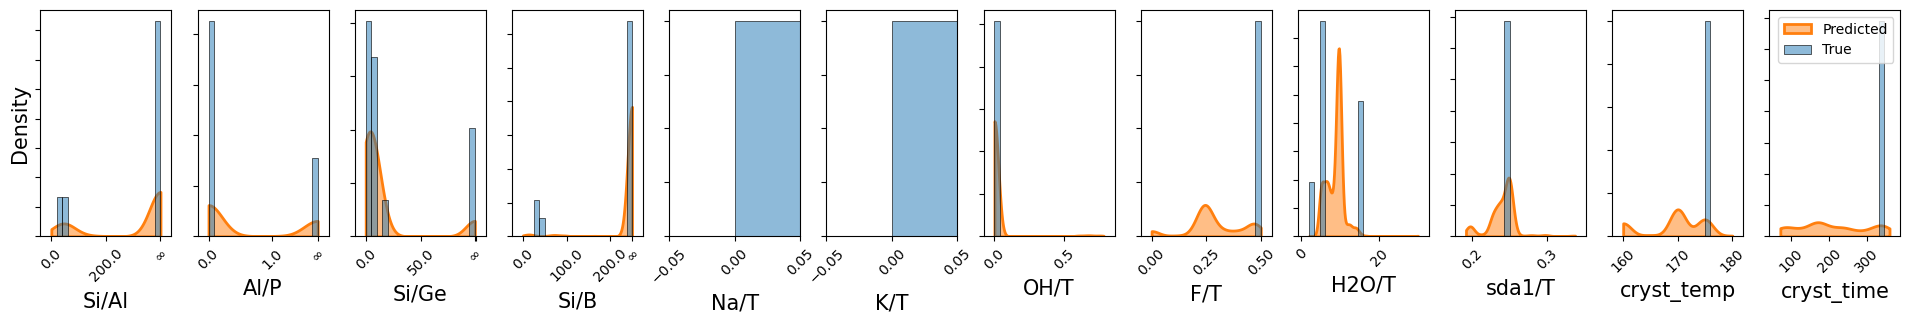

In [11]:
# Check BEC system for Si/Ge and F/T
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in reversed(zeo_osda_systems):
    if zeo == 'BEC':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        
        count += 1
        if count > 50:
            break